전처리 방식 수정 (다른 필터들 적용)

In [2]:
# pip install biosppy nolds scikit-learn peakutils

In [2]:
import wfdb
import numpy as np
import pandas as pd
import glob
import os
from wfdb import rdrecord
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from scipy import signal, fft
from scipy.signal import spectrogram
from biosppy.signals.ecg import christov_segmenter, hamilton_segmenter
from nolds import sampen
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import pywt
import wfdb
from wfdb.processing import gqrs_detect
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.stats import entropy
from multiprocessing import Pool, cpu_count
from sklearn.impute import SimpleImputer
import time
import scipy.ndimage
from scipy.stats import skew, kurtosis
from tqdm import tqdm

2025-03-27 16:09:13.252460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 16:09:13.253678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 16:09:13.257473: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-27 16:09:13.267277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743091753.283392   12047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743091753.28

### 함수 정의

In [47]:
# ✅ 웨이블릿 기반 노이즈 제거

def wavelet_denoise(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.median(np.abs(coeffs[-1])) / 0.6745
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

# ✅ 형태학적 필터를 이용한 기저선 제거

def oc_co_filter(signal, fs, k_factor):
    k_size = int(np.round(k_factor * fs))
    struct_elem = np.ones(k_size)
    opened = scipy.ndimage.grey_opening(signal, structure=struct_elem)
    closed = scipy.ndimage.grey_closing(opened, structure=struct_elem)
    return scipy.ndimage.grey_opening(closed, structure=struct_elem)

# ✅ 전처리 함수 (선택적으로 밴드패스 필터 추가)

def preprocess_ecg(signal_data, fs=400, use_bandpass=False):
    from scipy.signal import butter, filtfilt
    if signal_data.ndim == 2:
        cleaned = np.zeros_like(signal_data)
        for i in range(signal_data.shape[1]):
            x = signal_data[:, i]
            if use_bandpass:
                nyq = 0.5 * fs
                b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
                x = filtfilt(b, a, x)
            denoised = wavelet_denoise(x)
            baseline = oc_co_filter(denoised, fs, 0.27)
            cleaned[:, i] = denoised - baseline
        return cleaned
    else:
        x = signal_data
        if use_bandpass:
            nyq = 0.5 * fs
            b, a = butter(4, [0.1 / nyq, 45 / nyq], btype='band')
            x = filtfilt(b, a, x)
        denoised = wavelet_denoise(x)
        baseline = oc_co_filter(denoised, fs, 0.27)
        return denoised - baseline

# ✅ R 피크 검출

def detect_r_peaks(ecg_signal, fs=400):
    from wfdb.processing import gqrs_detect
    r_peaks = gqrs_detect(sig=ecg_signal, fs=fs)
    return r_peaks if len(r_peaks) > 1 else np.array([])

# ✅ QRS 및 QT 분석

def analyze_qrs_qt(ecg_signal, r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'qrs_width': np.nan, 'qt_interval': np.nan}
    qrs_widths = np.diff(r_peaks) / fs
    qt_intervals = []
    for r in r_peaks:
        if r + int(0.5 * fs) < len(ecg_signal):
            segment = ecg_signal[r:r + int(0.5 * fs)]
            peaks, _ = find_peaks(-segment)
            if len(peaks) > 0:
                qt_intervals.append((r + peaks[-1] - r) / fs)
    return {
        'qrs_width': np.nanmean(qrs_widths),
        'qt_interval': np.nanmean(qt_intervals) if qt_intervals else np.nan
    }

# ✅ HRV

def hrv_analysis(r_peaks, fs=400):
    if len(r_peaks) < 2:
        return {'rmssd': np.nan, 'sdnn': np.nan, 'sd1': np.nan, 
                'sd2': np.nan, 'sd_ratio': np.nan, 'heart_rate_mean': np.nan}
    rr_intervals = np.diff(r_peaks) / fs
    diff_rr = np.diff(rr_intervals)
    heart_rate = 60 / rr_intervals  # BPM
    return {
        'rmssd': np.sqrt(np.mean(diff_rr**2)),
        'sdnn': np.std(rr_intervals),
        'sd1': np.std(diff_rr) / np.sqrt(2),
        'sd2': np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2),
        'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) / 
                    (np.std(rr_intervals[:-1] + rr_intervals[1:]) / np.sqrt(2)),
        'heart_rate_mean': np.mean(heart_rate)
    }

# ✅ 주파수 분석

def frequency_analysis(ecg_signal, fs=400):
    freqs, power = welch(ecg_signal, fs=fs, nperseg=256)
    bands = {'ulf': (0.003, 0.04), 'vlf': (0.04, 0.15), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}
    total_energy = np.sum(power)
    band_energy = {band: np.sum(power[(freqs >= low) & (freqs < high)]) for band, (low, high) in bands.items()}
    return {k: v / total_energy if total_energy > 0 else 0 for k, v in band_energy.items()}

# ✅ 웨이블릿 특징

def extract_wavelet_features(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    features = {}
    total_energy = sum(np.sum(np.square(c)) for c in coeffs)
    entropies = [entropy(np.abs(c) / np.sum(np.abs(c)), base=2) if np.sum(np.abs(c)) > 0 else 0 for c in coeffs]
    for i, c in enumerate(coeffs):
        abs_c = np.abs(c)
        features[f'wavelet_L{i}_mean'] = np.mean(abs_c)
        features[f'wavelet_L{i}_std'] = np.std(c)
        features[f'wavelet_L{i}_energy'] = np.sum(np.square(c))
        features[f'wavelet_L{i}_energy_ratio'] = np.sum(np.square(c)) / total_energy if total_energy > 0 else 0
    features['wavelet_entropy'] = np.mean(entropies)
    return features

# ✅ 통합 ECG 특징 추출

def extract_features(ecg_signal, fs=400):
    filtered = preprocess_ecg(ecg_signal, fs)
    r_peaks = detect_r_peaks(filtered, fs)
    return {
        **analyze_qrs_qt(filtered, r_peaks, fs),
        **hrv_analysis(r_peaks, fs),
        **frequency_analysis(filtered, fs),
        **extract_wavelet_features(filtered),
        'skewness': skew(filtered),
        'kurtosis': kurtosis(filtered)
    }

# ✅ 진행률 포함 처리 함수

def process_with_progress(df, num_samples=None, fs=400, lead_index=0, use_bandpass=False, include_metadata=True):
    start_time = time.time()
    if num_samples is None:
        df_sample = df.copy().reset_index(drop=True)
    else:
        df_sample = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    all_rows = []

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="🔹 특징 추출 중", dynamic_ncols=True):
        try:
            ecg_signal = row["p_signal"][:, lead_index]
            features = extract_features(ecg_signal, fs=fs)

            # ✅ 리드 인덱스 붙여서 컬럼명 변경
            features = {f"{lead_index}_{k}": v for k, v in features.items()}

            if include_metadata:
                metadata = row.drop("p_signal").to_dict()
                metadata["Age_gap"] = metadata.get("Age", np.nan) - metadata.get("nn_predicted_age", np.nan)
                merged = {**features, **metadata}
            else:
                merged = {**features, "exam_id": row["exam_id"]}

            all_rows.append(merged)
        except Exception as e:
            print(f"⚠️ 오류 발생: {e} (샘플 {idx} 건너뜀)")
            continue

    df_features = pd.DataFrame(all_rows)

    if df_features.empty:
        print("❌ 모든 샘플에서 특징 추출 실패.")
        return None

    df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_features = df_features.dropna(axis=1, thresh=0.6 * len(df_features))

    end_time = time.time()
    print(f"\n✅ 총 {len(df_features)}개 샘플 특징 추출 완료! (소요시간: {end_time - start_time:.2f}초)")

    return df_features

### code15 데이터 처리

피처 추출 (lead2: index1)

In [71]:
df_part0 = pd.read_pickle("/workspace/my_data/code15_part0.pkl")
df_part1 = pd.read_pickle("/workspace/my_data/code15_part1.pkl")

In [72]:
df0 = process_with_progress(df_part0, lead_index=1, use_bandpass=False, include_metadata=True)
df1 = process_with_progress(df_part1, lead_index=1, use_bandpass=False, include_metadata=True)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.                | 99/19901 [00:03<10:04, 32.73it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice. 

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 8011 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 8324/19901 [04:06<05:29, 35.12it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice. 

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13186 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                        | 13246/19901 [06:30<03:16, 33.93it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                        | 13406/19901 [06:35<03:00, 35.99it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                        | 13442/19901 [06:36<03:18, 32.60it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                        | 13712/19901 [06:44<02:56, 34.98it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                        | 14130/19901 [06:56<02:51, 33.60it/s]
  'sd_ratio'


✅ 총 19899개 샘플 특징 추출 완료! (소요시간: 586.87초)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.                | 64/19897 [00:01<09:22, 35.26it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered i

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 17844 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide████████████████▏      | 18598/19897 [09:07<00:37, 34.32it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide    | 18730/19897 [09:11<00:33, 34.35it/s]
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide█████████████████▉      | 18746/19897 [09:12<00:33, 33.98it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide██████████████████▍     | 18830/19897 [09:14<00:30, 35.03it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide███████████████████     | 18946/19897 [09:18<00:29, 31.99it/s]
  'sd_ratio': (np.std


✅ 총 19896개 샘플 특징 추출 완료! (소요시간: 586.61초)


In [74]:
# 위아래로 이어 붙이기 (row 방향 concat)
df_1 = pd.concat([df0, df1], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df_1

✅ 전체 샘플 수: 39775


,1_qrs_width,1_qt_interval,1_rmssd,1_sdnn,1_sd1,1_sd2,1_sd_ratio,1_heart_rate_mean,1_ulf,1_vlf,...,exam_id,Age,Chagas_label,is_male,nn_predicted_age,RBBB,LBBB,AF,normal_ecg,Age_gap
0,0.727500,0.471154,0.050239,0.036834,0.034752,0.028379,1.224569,82.673532,0.0,0.0,...,1398216,35,0,0,50.454483,0,0,0,0,-15.454483
1,1.089286,0.485312,0.182332,0.115370,0.127669,0.111222,1.147881,55.712239,0.0,0.0,...,620215,19,0,0,28.217638,0,0,0,1,-9.217638
2,0.650000,0.485556,0.007962,0.006847,0.005345,0.005345,1.000000,92.318153,0.0,0.0,...,712938,59,0,0,67.447525,0,0,0,0,-8.447525
3,0.936667,0.481000,0.021920,0.021667,0.015460,0.028249,0.547281,64.091340,0.0,0.0,...,1504935,60,0,0,64.676575,0,0,0,1,-4.676575
4,0.767500,0.485000,0.023261,0.027300,0.015081,0.030449,0.495266,78.271717,0.0,0.0,...,1229800,58,0,0,66.523140,0,0,0,0,-8.523140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39790,0.872143,0.480000,0.018371,0.024438,0.011577,0.031502,0.367504,68.849077,0.0,0.0,...,1549519,40,0,1,66.570370,0,0,0,1,-26.570370
39791,0.804583,0.480714,0.010124,0.012112,0.005172,0.013351,0.387389,74.589653,0.0,0.0,...,4208809,36,0,1,31.170006,0,0,0,0,4.829994
39792,0.697708,0.464038,0.269247,0.172033,0.190386,0.167015,1.139932,89.113990,0.0,0.0,...,475767,61,0,0,61.709570,0,0,0,1,-0.709570
39793,1.028571,0.487187,0.030139,0.022514,0.020908,0.025021,0.835632,58.361238,0.0,0.0,...,1524075,40,0,0,57.973840,0,0,0,1,-17.973840


7번 리드 특징 추출 (index=6)

In [42]:
df_part0 = pd.read_pickle("/workspace/my_data/code15_part0.pkl")
df_part1 = pd.read_pickle("/workspace/my_data/code15_part1.pkl")

In [48]:
df0 = process_with_progress(df_part0, lead_index=6, use_bandpass=False, include_metadata=False)
df1 = process_with_progress(df_part1, lead_index=6, use_bandpass=False, include_metadata=False)

🔹 특징 추출 중:   1%|▊                                                                                                         | 157/19901 [00:05<08:32, 38.50it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 149 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                          | 603/19901 [00:18<09:39, 33.31it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:   3%|███▎                                                                                                      | 616/19901 [00:18<08:51, 36.25it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 609 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide                        | 1122/19901 [00:33<09:34, 32.67it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:  11%|███████████▎                                                                                             | 2137/19901 [01:02<08:29, 34.90it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 2132 건너뜀)


🔹 특징 추출 중:  22%|███████████████████████▏                                                                                 | 4399/19901 [02:08<06:54, 37.38it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 4391 건너뜀)


🔹 특징 추출 중:  40%|██████████████████████████████████████████▎                                                              | 8015/19901 [03:54<05:27, 36.30it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 8011 건너뜀)


/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.s]
  warnings.warn(
🔹 특징 추출 중:  46%|████████████████████████████████████████████████▍                                                        | 9176/19901 [04:27<04:54, 36.46it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9172 건너뜀)


🔹 특징 추출 중:  55%|█████████████████████████████████████████████████████████▏                                              | 10951/19901 [05:19<04:00, 37.26it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10944 건너뜀)


🔹 특징 추출 중:  66%|████████████████████████████████████████████████████████████████████▎                                   | 13064/19901 [06:20<03:13, 35.37it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13059 건너뜀)


🔹 특징 추출 중:  67%|██████████████████████████████████████████████████████████████████████                                  | 13395/19901 [06:30<02:50, 38.09it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13389 건너뜀)


🔹 특징 추출 중:  68%|███████████████████████████████████████████████████████████████████████▏                                | 13617/19901 [06:36<02:57, 35.43it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13613 건너뜀)


🔹 특징 추출 중:  74%|████████████████████████████████████████████████████████████████████████████▊                           | 14690/19901 [07:07<02:21, 36.74it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 14684 건너뜀)


🔹 특징 추출 중:  77%|████████████████████████████████████████████████████████████████████████████████▎                       | 15366/19901 [07:26<02:02, 37.15it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 15358 건너뜀)


🔹 특징 추출 중: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 19901/19901 [09:38<00:00, 34.42it/s]



✅ 총 19889개 샘플 특징 추출 완료! (소요시간: 578.39초)


/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide       | 92/19897 [00:02<09:16, 35.59it/s]
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                          | 985/19897 [00:28<08:57, 35.20it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 1185/19897 [00:34<09:11, 33.92it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/nu

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 1994 건너뜀)


🔹 특징 추출 중:  10%|██████████▉                                                                                              | 2073/19897 [01:00<07:56, 37.42it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 2069 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide                        | 3470/19897 [01:41<07:42, 35.48it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 17848/19897 [08:36<00:57, 35.48it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 17844 건너뜀)


🔹 특징 추출 중:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 19307/19897 [09:19<00:16, 36.14it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 19299 건너뜀)


🔹 특징 추출 중: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 19897/19897 [09:36<00:00, 34.52it/s]



✅ 총 19893개 샘플 특징 추출 완료! (소요시간: 576.53초)


In [49]:
# 위아래로 이어 붙이기 (row 방향 concat)
df_2 = pd.concat([df0, df1], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df_2

✅ 전체 샘플 수: 39790


,6_qrs_width,6_qt_interval,6_rmssd,6_sdnn,6_sd1,6_sd2,6_sd_ratio,6_heart_rate_mean,6_ulf,6_vlf,...,6_wavelet_L3_energy,6_wavelet_L3_energy_ratio,6_wavelet_L4_mean,6_wavelet_L4_std,6_wavelet_L4_energy,6_wavelet_L4_energy_ratio,6_wavelet_entropy,6_skewness,6_kurtosis,exam_id
0,0.719375,0.481154,0.041100,0.024498,0.029040,0.020699,1.402959,83.500678,0.0,0.0,...,0.618064,0.001268,0.001530,0.004119,0.034798,0.000071,7.546762,-3.148257,15.201472,1398216
1,1.089643,0.481250,0.182905,0.115476,0.128037,0.110774,1.155839,55.695078,0.0,0.0,...,0.349231,0.000732,0.001341,0.005154,0.054486,0.000114,7.180743,-4.059623,22.010973,620215
2,0.619722,0.479750,0.067593,0.071282,0.044044,0.063246,0.696391,98.597682,0.0,0.0,...,4340.768028,0.248063,0.069960,0.681356,682.441223,0.039000,5.153898,9.028962,115.990020,712938
3,0.937222,0.481250,0.022291,0.021713,0.015737,0.028281,0.556458,64.053647,0.0,0.0,...,0.138809,0.001441,0.001976,0.003793,0.029717,0.000309,7.798378,-1.175567,7.121301,1504935
4,0.767500,0.481389,0.021630,0.026458,0.013814,0.029329,0.470985,78.265560,0.0,0.0,...,1.042669,0.008792,0.003024,0.005319,0.041590,0.000351,7.534629,-3.113487,17.712945,1229800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39777,0.871786,0.487187,0.015943,0.023441,0.009610,0.030340,0.316764,68.873270,0.0,0.0,...,0.288539,0.001145,0.002637,0.003954,0.022985,0.000091,7.789942,-2.841866,10.320620,1549519
39778,0.804583,0.487500,0.010124,0.012112,0.005172,0.013351,0.387389,74.589653,0.0,0.0,...,1.223876,0.003953,0.002938,0.006172,0.056009,0.000181,7.117779,-4.200887,22.173762,4208809
39779,0.644231,0.463393,0.006081,0.009726,0.004277,0.013238,0.323104,93.155507,0.0,0.0,...,0.139052,0.000593,0.001043,0.001557,0.004975,0.000021,7.797099,-4.094561,16.857459,475767
39780,1.028929,0.487500,0.029065,0.022593,0.020071,0.025524,0.786376,58.341169,0.0,0.0,...,0.208432,0.000784,0.001278,0.001910,0.007481,0.000028,7.837036,-4.732351,23.794567,1524075


피처 추출 (lead8: index7)

In [75]:
df0_8 = process_with_progress(df_part0, lead_index=7, use_bandpass=False, include_metadata=False)
df1_8 = process_with_progress(df_part1, lead_index=7, use_bandpass=False, include_metadata=False)

/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                           | 74/19901 [00:03<10:59, 30.04it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide      | 146/19901 [00:05<09:12, 35.76it/s]
  thresholded = (1 - value/magnitude)
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:829: RuntimeWarning: All-NaN slice encountered
  minvals = np.nanmin(self.p_signal, axis=0)
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:830: RuntimeWarning: All-NaN slice encountered
  maxvals = np.nanmax(self.p_signal, axis=0)
🔹 특징 추출 중:   1%|▊                                                                                                         | 155/19901 [00:05<08:38, 38.10it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 149 건너뜀)


🔹 특징 추출 중:   1%|█▎                                                                                                        | 240/19901 [00:07<09:11, 35.62it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 233 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.               | 280/19901 [00:08<09:31, 34.30it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
🔹 특징 추출 중:   1%|█▌                                                                                           

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 284 건너뜀)


🔹 특징 추출 중:  11%|███████████▎                                                                                             | 2137/19901 [01:03<08:31, 34.75it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 2132 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide                        | 3290/19901 [01:37<07:58, 34.73it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:  17%|██████████████████▎                                                                                      | 3479/19901 [01:42<07:41, 35.60it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 3474 건너뜀)


🔹 특징 추출 중:  40%|█████████████████████████████████████████▌                                                               | 7882/19901 [03:51<05:43, 35.02it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 7878 건너뜀)


🔹 특징 추출 중:  40%|██████████████████████████████████████████▎                                                              | 8015/19901 [03:55<05:29, 36.03it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 8011 건너뜀)


🔹 특징 추출 중:  43%|████████████████████████████████████████████▊                                                            | 8504/19901 [04:10<05:35, 34.00it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 8498 건너뜀)


/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.s]
  warnings.warn(
🔹 특징 추출 중:  46%|████████████████████████████████████████████████▍                                                        | 9178/19901 [04:29<05:06, 34.97it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9172 건너뜀)


🔹 특징 추출 중:  52%|██████████████████████████████████████████████████████▍                                                 | 10405/19901 [05:05<04:14, 37.25it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10399 건너뜀)


🔹 특징 추출 중:  55%|████████████████████████████████████████████████████████▉                                               | 10899/19901 [05:20<04:00, 37.44it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10894 건너뜀)


🔹 특징 추출 중:  61%|███████████████████████████████████████████████████████████████▌                                        | 12156/19901 [05:57<03:43, 34.63it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 12151 건너뜀)


🔹 특징 추출 중:  66%|████████████████████████████████████████████████████████████████████▎                                   | 13065/19901 [06:23<03:21, 33.88it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13059 건너뜀)


🔹 특징 추출 중:  66%|████████████████████████████████████████████████████████████████████▉                                   | 13194/19901 [06:27<03:04, 36.40it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13186 건너뜀)


🔹 특징 추출 중:  67%|██████████████████████████████████████████████████████████████████████                                  | 13395/19901 [06:33<02:53, 37.58it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13389 건너뜀)


🔹 특징 추출 중:  68%|███████████████████████████████████████████████████████████████████████▏                                | 13617/19901 [06:39<03:00, 34.90it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 13613 건너뜀)


🔹 특징 추출 중:  71%|██████████████████████████████████████████████████████████████████████████▏                             | 14191/19901 [06:56<02:38, 35.96it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 14185 건너뜀)


🔹 특징 추출 중:  82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 16236/19901 [07:56<01:48, 33.83it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 16230 건너뜀)


🔹 특징 추출 중:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎    | 19004/19901 [09:17<00:23, 38.13it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 18996 건너뜀)
⚠️ 오류 발생: cannot convert float NaN to integer (샘플 19002 건너뜀)


🔹 특징 추출 중: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 19901/19901 [09:43<00:00, 34.12it/s]



✅ 총 19881개 샘플 특징 추출 완료! (소요시간: 583.46초)


/opt/conda/lib/python3.10/site-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide       | 92/19897 [00:02<09:18, 35.49it/s]
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: invalid value encountered in scalar divide                          | 612/19897 [00:17<09:30, 33.79it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:829: RuntimeWarning: All-NaN slice encountered                  | 800/19897 [00:23<09:40, 32.91it/s]
  minvals = np.nanmin(self.p_signal, axis=0)
/opt/conda/lib/python3.10/site-packages/wfdb/io/_signal.py:830: RuntimeWarning: All-NaN slice encountered
  maxvals = np.nanmax(self.p_signal, axis=0)
🔹 특징 추출 중:   4%|████▎                                                                                                     | 804/19897 [00:23<09:10, 34.70it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 800 건너뜀)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.              | 1185/19897 [00:34<09:12, 33.89it/s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
🔹 특징 추출 중:   7%|███████                                                                                      

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 1345 건너뜀)


🔹 특징 추출 중:   7%|███████▍                                                                                                 | 1403/19897 [00:41<08:22, 36.83it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 1398 건너뜀)


🔹 특징 추출 중:  13%|█████████████▌                                                                                           | 2579/19897 [01:15<07:32, 38.29it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 2574 건너뜀)


/tmp/ipykernel_12047/2324083429.py:83: RuntimeWarning: divide by zero encountered in scalar divide                        | 3470/19897 [01:41<07:46, 35.18it/s]
  'sd_ratio': (np.std(diff_rr) / np.sqrt(2)) /
🔹 특징 추출 중:  20%|████████████████████▊                                                                                    | 3936/19897 [01:55<07:25, 35.85it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 3930 건너뜀)


🔹 특징 추출 중:  25%|█████████████████████████▊                                                                               | 4902/19897 [02:23<06:53, 36.28it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 4897 건너뜀)


🔹 특징 추출 중:  47%|█████████████████████████████████████████████████                                                        | 9298/19897 [04:32<05:28, 32.28it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9294 건너뜀)


🔹 특징 추출 중:  48%|█████████████████████████████████████████████████▉                                                       | 9472/19897 [04:38<06:16, 27.69it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 9468 건너뜀)


🔹 특징 추출 중:  52%|██████████████████████████████████████████████████████                                                  | 10336/19897 [05:03<04:30, 35.31it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 10329 건너뜀)


🔹 특징 추출 중:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 17850/19897 [08:43<00:59, 34.42it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 17844 건너뜀)


🔹 특징 추출 중:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 19304/19897 [09:25<00:16, 36.63it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 19299 건너뜀)


🔹 특징 추출 중:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 19643/19897 [09:35<00:06, 36.57it/s]

⚠️ 오류 발생: cannot convert float NaN to integer (샘플 19635 건너뜀)


🔹 특징 추출 중: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 19897/19897 [09:43<00:00, 34.13it/s]



✅ 총 19885개 샘플 특징 추출 완료! (소요시간: 583.24초)


In [76]:
# 위아래로 이어 붙이기 (row 방향 concat)
df_8 = pd.concat([df0_8, df1_8], axis=0).reset_index(drop=True)

# 결과 확인
print(f"✅ 전체 샘플 수: {len(df)}")
df_8

✅ 전체 샘플 수: 39775


,7_qrs_width,7_qt_interval,7_rmssd,7_sdnn,7_sd1,7_sd2,7_sd_ratio,7_heart_rate_mean,7_ulf,7_vlf,...,7_wavelet_L3_energy,7_wavelet_L3_energy_ratio,7_wavelet_L4_mean,7_wavelet_L4_std,7_wavelet_L4_energy,7_wavelet_L4_energy_ratio,7_wavelet_entropy,7_skewness,7_kurtosis,exam_id
0,0.688636,0.477708,0.134958,0.113365,0.091569,0.078957,1.159728,91.608632,0.0,0.0,...,0.439518,0.000439,0.001445,0.004780,0.046902,0.000047,7.313173,-1.994119,10.350964,1398216
1,1.089643,0.480000,0.181722,0.114552,0.127275,0.110080,1.156201,55.685456,0.0,0.0,...,0.246354,0.000589,0.000972,0.001619,0.005382,0.000013,7.223055,-4.383676,27.123810,620215
2,0.650000,0.483611,0.008814,0.007395,0.005976,0.006268,0.953463,92.319825,0.0,0.0,...,3.362594,0.008626,0.005028,0.012929,0.245761,0.000630,7.795881,1.969519,8.381176,712938
3,0.936667,0.489250,0.022185,0.021602,0.015662,0.028021,0.558961,64.091136,0.0,0.0,...,0.376850,0.002224,0.002282,0.005343,0.058862,0.000347,7.461592,-2.425608,16.854442,1504935
4,0.770938,0.485556,0.027435,0.027040,0.019026,0.028058,0.678099,77.920948,0.0,0.0,...,1.770378,0.017370,0.003130,0.006421,0.060610,0.000595,7.293694,-0.421405,17.385413,1229800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39761,0.871786,0.484687,0.017048,0.024191,0.010346,0.031171,0.331901,68.876373,0.0,0.0,...,5.852113,0.005232,0.004118,0.019969,0.586239,0.000524,6.898522,-2.292065,11.538735,1549519
39762,0.804583,0.488571,0.010124,0.012112,0.005172,0.013351,0.387389,74.589653,0.0,0.0,...,1.765466,0.008049,0.003098,0.006390,0.060029,0.000274,7.049802,-2.728153,15.719743,4208809
39763,0.641538,0.468750,0.010483,0.010540,0.007293,0.012398,0.588251,93.550343,0.0,0.0,...,0.371926,0.001980,0.001304,0.002246,0.010350,0.000055,7.739565,-1.354858,7.787265,475767
39764,0.583594,0.480469,0.496622,0.277369,0.350458,0.182256,1.922883,134.252736,0.0,0.0,...,0.721988,0.000470,0.001341,0.002295,0.010802,0.000007,7.379800,-3.579272,17.679082,1524075


In [77]:
# 두 데이터셋 조인 (리드2,7)
temp = pd.merge(df_1, df_2, on='exam_id', how='inner')
# 두 데이터셋 조인 (전체3개)
df = pd.merge(temp, df_8, on='exam_id', how='inner')

In [78]:
df

,1_qrs_width,1_qt_interval,1_rmssd,1_sdnn,1_sd1,1_sd2,1_sd_ratio,1_heart_rate_mean,1_ulf,1_vlf,...,7_wavelet_L3_std,7_wavelet_L3_energy,7_wavelet_L3_energy_ratio,7_wavelet_L4_mean,7_wavelet_L4_std,7_wavelet_L4_energy,7_wavelet_L4_energy_ratio,7_wavelet_entropy,7_skewness,7_kurtosis
0,0.727500,0.471154,0.050239,0.036834,0.034752,0.028379,1.224569,82.673532,0.0,0.0,...,0.020639,0.439518,0.000439,0.001445,0.004780,0.046902,0.000047,7.313173,-1.994119,10.350964
1,1.089286,0.485312,0.182332,0.115370,0.127669,0.111222,1.147881,55.712239,0.0,0.0,...,0.015467,0.246354,0.000589,0.000972,0.001619,0.005382,0.000013,7.223055,-4.383676,27.123810
2,0.650000,0.485556,0.007962,0.006847,0.005345,0.005345,1.000000,92.318153,0.0,0.0,...,0.067495,3.362594,0.008626,0.005028,0.012929,0.245761,0.000630,7.795881,1.969519,8.381176
3,0.936667,0.481000,0.021920,0.021667,0.015460,0.028249,0.547281,64.091340,0.0,0.0,...,0.019036,0.376850,0.002224,0.002282,0.005343,0.058862,0.000347,7.461592,-2.425608,16.854442
4,0.767500,0.485000,0.023261,0.027300,0.015081,0.030449,0.495266,78.271717,0.0,0.0,...,0.048977,1.770378,0.017370,0.003130,0.006421,0.060610,0.000595,7.293694,-0.421405,17.385413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39754,0.872143,0.480000,0.018371,0.024438,0.011577,0.031502,0.367504,68.849077,0.0,0.0,...,0.089037,5.852113,0.005232,0.004118,0.019969,0.586239,0.000524,6.898522,-2.292065,11.538735
39755,0.804583,0.480714,0.010124,0.012112,0.005172,0.013351,0.387389,74.589653,0.0,0.0,...,0.048910,1.765466,0.008049,0.003098,0.006390,0.060029,0.000274,7.049802,-2.728153,15.719743
39756,0.697708,0.464038,0.269247,0.172033,0.190386,0.167015,1.139932,89.113990,0.0,0.0,...,0.019011,0.371926,0.001980,0.001304,0.002246,0.010350,0.000055,7.739565,-1.354858,7.787265
39757,1.028571,0.487187,0.030139,0.022514,0.020908,0.025021,0.835632,58.361238,0.0,0.0,...,0.026488,0.721988,0.000470,0.001341,0.002295,0.010802,0.000007,7.379800,-3.579272,17.679082


In [79]:
df.to_pickle('/workspace/my_data/lead278_processed')

### 모델링

In [39]:
# pip install --upgrade xgboost

In [129]:
# pip install imbalanced-learn

In [80]:
import numpy as np
import pandas as pd
import time
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback

# X, y 나누기
def preprocess_dataframe(df):
    """데이터프레임에서 NaN 처리 및 feature, target 분리"""
    df = df.dropna(axis=1, thresh=0.5 * len(df))  # NaN이 50% 이상인 컬럼 제거

    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df.drop(columns=["Chagas_label"]))
    y = df["Chagas_label"].values  # 타겟 변수 분리

    return X, y

# 데이터 스플릿 (8:2)
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# CatBoost parameter 최적화 함수
def objective_catboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

    
# ✅ Catboost 학습
def train_catboost(X_train, y_train, X_test, y_test, **params):
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    return model


# ✅ 모델 평가
def evaluate_model(model, X_test, y_test, model_name):
    """Confusion Matrix 및 성능 지표 출력"""
    y_pred = model.predict(X_test)
    
    print(f"\n✅ {model_name} 모델 평가")
    print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
    print("🔹 F1 Score:", f1_score(y_test, y_pred))
    print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    
# ✅ Feature Importance 시각화
def plot_feature_importance(model, feature_names):
    """Feature Importance 시각화"""
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]  # 중요도가 높은 순 정렬

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Top 10 Feature Importances")
    plt.show()

In [81]:
df.drop(columns=['exam_id'], inplace=True)

In [82]:
df.columns

Index(['1_qrs_width', '1_qt_interval', '1_rmssd', '1_sdnn', '1_sd1', '1_sd2',
       '1_sd_ratio', '1_heart_rate_mean', '1_ulf', '1_vlf',
       ...
       '7_wavelet_L3_std', '7_wavelet_L3_energy', '7_wavelet_L3_energy_ratio',
       '7_wavelet_L4_mean', '7_wavelet_L4_std', '7_wavelet_L4_energy',
       '7_wavelet_L4_energy_ratio', '7_wavelet_entropy', '7_skewness',
       '7_kurtosis'],
      dtype='object', length=114)

데이터 스케일링 및 스플릿

In [83]:
df['age_gap'] = df['Age']-df['nn_predicted_age']

In [96]:
from sklearn.model_selection import train_test_split

# 함수 실행
X, y = preprocess_dataframe(df)  # 데이터 분석 전에 전처리

# # 스케일링
# X_categorical = df[['Age', 'is_male', 'nn_predicted_age', 'normal_ecg', 'RBBB',  'LBBB', 'AF', "age_gap"]]
# X_numeric = df.drop(columns=X_categorical.columns)

# # Scaling
# scaler = StandardScaler()
# X_numeric_scaled = scaler.fit_transform(X_numeric)

# # 다시 합치기
# X = np.hstack([X_numeric_scaled, X_categorical])

In [97]:
# 스플릿
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 불균형 고려
)

### Catboost

In [98]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_catboost, n_trials=10)

best_params_cat = study_cat.best_params
print("최적 CatBoost 하이퍼파라미터:", best_params_cat)

[I 2025-03-27 18:27:47,599] A new study created in memory with name: no-name-59f262b6-4ce6-42aa-b876-d4d2d095fcca
/tmp/ipykernel_12047/273896562.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_12047/273896562.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
/tmp/ipykernel_12047/273896562.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_temperature': trial.sug

최적 CatBoost 하이퍼파라미터: {'n_estimators': 1097, 'depth': 5, 'learning_rate': 0.29080421398717854, 'l2_leaf_reg': 0.4853729791623361, 'bagging_temperature': 0.49505552405893005}


In [119]:
# 모델 학습

catboost_model = CatBoostClassifier(
                    **best_params_cat,
                    class_weights = [1,20],
                    verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)

# ✅ 3. CatBoost 모델 평가
y_pred_cat = catboost_model.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")

## 가중치 줄 경우 (1,5)
# CatBoost Accuracy: 0.9763
# CatBoost F1 Score: 0.2286

CatBoost Accuracy: 0.9319
CatBoost F1 Score: 0.2063


In [101]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7788
           1       0.22      0.26      0.24       164

    accuracy                           0.97      7952
   macro avg       0.60      0.62      0.61      7952
weighted avg       0.97      0.97      0.97      7952



In [120]:
from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy 계산
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy: {balanced_acc:.4f}")

Balanced Accuracy: 0.5092


In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# ✅ 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
acc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model_cv = CatBoostClassifier(
        **best_params_cat,
        class_weights=[1, 10],
        verbose=0
    )

    model_cv.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), early_stopping_rounds=50, verbose=0)

    preds = model_cv.predict(X_val_cv)
    
    acc = accuracy_score(y_val_cv, preds)
    f1 = f1_score(y_val_cv, preds)

    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

print("\n교차 검증 결과 (5-Fold)")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

Fold 1 - Accuracy: 0.9671, F1 Score: 0.2249
Fold 2 - Accuracy: 0.9692, F1 Score: 0.2368
Fold 3 - Accuracy: 0.9686, F1 Score: 0.2560
Fold 4 - Accuracy: 0.9660, F1 Score: 0.2241
Fold 5 - Accuracy: 0.9645, F1 Score: 0.2337

교차 검증 결과 (5-Fold)
Average Accuracy: 0.9671
Average F1 Score: 0.2351


임계값 조정

✅ 최적 Threshold: 0.54
✅ F1 Score (최적 threshold): 0.2468
✅ Accuracy: 0.9700704225352113

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      7788
           1       0.26      0.24      0.25       164

    accuracy                           0.97      7952
   macro avg       0.62      0.61      0.62      7952
weighted avg       0.97      0.97      0.97      7952



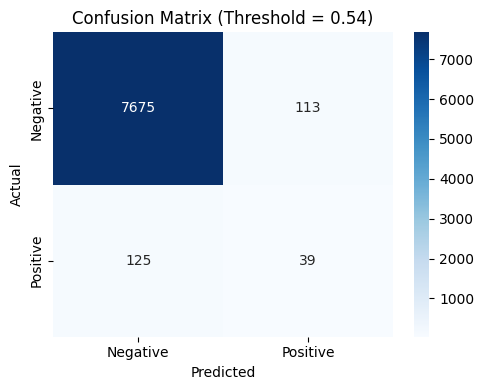

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# 1. 확률 예측
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

# 2. 다양한 threshold에서 F1 score 계산
thresholds = np.linspace(0.1, 0.9, 50)
f1s = []

for t in thresholds:
    preds = (y_pred_prob >= t).astype(int)
    f1s.append(f1_score(y_test, preds))

# 3. 최적 threshold
best_threshold = thresholds[np.argmax(f1s)]
best_f1 = max(f1s)

# 4. 최적 threshold로 예측
y_pred_best = (y_pred_prob >= best_threshold).astype(int)

# 5. 성능 출력
print(f"✅ 최적 Threshold: {best_threshold:.2f}")
print(f"✅ F1 Score (최적 threshold): {best_f1:.4f}")
print("✅ Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# 6. Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

Feature importance

/tmp/ipykernel_12047/273896562.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx[:10]], y=np.array(feature_names)[sorted_idx[:10]], palette="viridis")


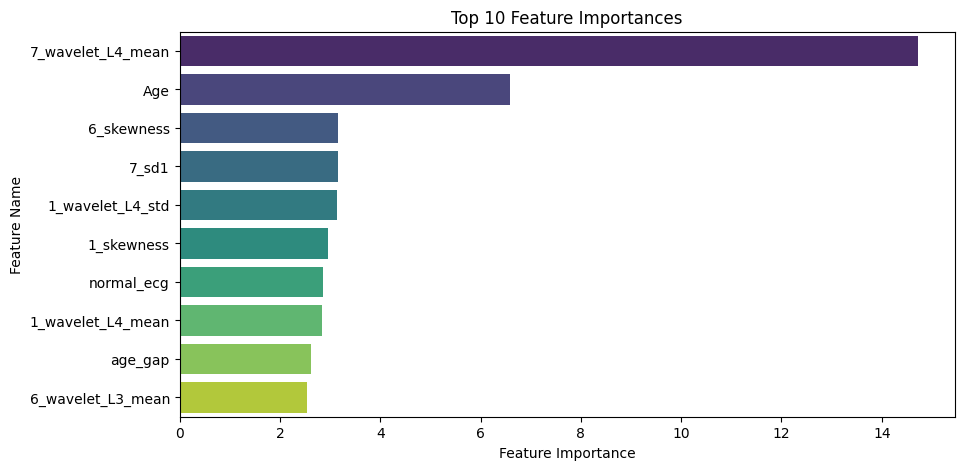

In [104]:
# feature importance
feature_names = df.drop(columns=["Chagas_label"]).columns.tolist()
plot_feature_importance(catboost_model, feature_names)

In [105]:
# Challenge score

from helper_code import compute_challenge_score  # helper_code에서 함수 가져오기

# 모델 예측값 (확률 기반)
y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]  # 모델이 1(양성)일 확률 예측

# 실제 라벨
y_true = y_test  # 실제 정답 레이블 (0 또는 1)

# ✅ Challenge Score 계산
challenge_score = compute_challenge_score(y_true, y_pred_prob)

print(f"Challenge Score: {challenge_score:.3f}")


# Challenge Score: 0.396

Challenge Score: 0.396


상관계수 높은 피처 제거

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def remove_highly_correlated_features(df, threshold=0.9):
    """
    상관계수가 threshold 이상인 피처 중 하나를 제거.
    
    Parameters:
    - df: 입력 DataFrame (수치형 피처만 포함해야 함)
    - threshold: 상관계수 기준 (default: 0.9)
    
    Returns:
    - 제거된 컬럼 목록
    - 제거 후 DataFrame
    """
    # 상관계수 행렬
    corr_matrix = df.corr().abs()

    # 상삼각행렬만 사용 (중복 제거)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 상관계수가 threshold보다 큰 컬럼 쌍에서 하나씩 제거
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"🔻 상관계수 {threshold} 초과로 제거된 피처 수: {len(to_drop)}")
    return to_drop, df.drop(columns=to_drop)


def plot_correlation_heatmap(df, figsize=(16, 12), threshold=0.9):
    """
    상관계수 히트맵 시각화 함수
    
    Parameters:
    - df: 수치형 피처만 포함된 DataFrame
    - figsize: 플롯 크기 설정
    - threshold: 상관계수 기준선 (선택적으로 표시)
    """
    corr = df.corr()

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, fmt=".2f",
                cbar_kws={"shrink": 0.8}, square=True)
    plt.title("📊 Feature Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 강한 상관 피처 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                pair = (corr.columns[i], corr.columns[j], corr.iloc[i, j])
                high_corr_pairs.append(pair)

    if high_corr_pairs:
        print(f"\n🔎 상관계수 {threshold} 초과 피처쌍:")
        for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"  {feat1} ↔ {feat2} : {corr_val:.2f}")
    else:
        print(f"\n✅ 상관계수 {threshold} 초과 피처쌍 없음.")


### TabNet

In [114]:
# ✅ TensorFlow 기반 이진 분류 파이프라인
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# ✅ 전처리 함수
def preprocess_tf(df, target_col="Chagas_label"):
    df = df.dropna(axis=1, thresh=0.5 * len(df))
    imputer = SimpleImputer(strategy="median")

    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)

    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y.values, X.columns

# ✅ 모델 생성 함수
def build_tf_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ✅ 학습 함수
def train_tf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = build_tf_model(X.shape[1])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=256,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    return model, X_test, y_test

def resnet_block(x, units, dropout_rate=0.3):
    shortcut = x
    x = Dense(units, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])  # Residual 연결
    x = tf.keras.activations.relu(x)
    return x

def build_resnet_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ 평가 함수
def evaluate(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    print("\n 모델 평가")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("TensorFlow Confusion Matrix")
    plt.show()

# 전체 실행
def run_tf_pipeline(df):
    X, y, feature_names = preprocess_tf(df)
    model, X_test, y_test = train_tf(X, y)
    evaluate(model, X_test, y_test)
    return model

In [113]:
# ✅ ResNet 모델 Accuracy 평가 (Keras 내장 evaluate 함수 사용)
resnet_accuracy = resnet_model.evaluate(X_test, y_test, verbose=0)[1]  # [0]: loss, [1]: accuracy
resnet_preds_test = (resnet_model.predict(X_test) > 0.3).astype(int)
resnet_f1 = f1_score(y_test, resnet_preds_test)

print(f"ResNet Model Accuracy: {resnet_accuracy:.4f}")
print(f"ResNet Model F1 Score: {resnet_f1:.4f}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
ResNet Model Accuracy: 0.9793
ResNet Model F1 Score: 0.0000
